In [1]:
# pip install xgboost

In [2]:
# pip install catboost

In [3]:
# pip install imblearn

In [4]:
# pip install pyecharts

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import pyecharts as py
# from py import options as opts
# from py.charts import Sankey
import warnings

%matplotlib inline
%config InlineBackend.figure_format ="svg"
warnings.filterwarnings("ignore")

import sklearn
from sklearn import preprocessing #數據預處理
from sklearn.preprocessing import LabelEncoder #編碼轉換
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import StratifiedShuffleSplit #分層抽樣
from sklearn.model_selection import GridSearchCV #網路搜索
from sklearn.ensemble import RandomForestClassifier #隨機森林
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier #梯度提升
from sklearn.ensemble import  VotingClassifier #集成學習
from sklearn.svm import SVC,LinearSVC #支持向量機
from sklearn.linear_model import LogisticRegression #邏輯回歸
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #樸素貝葉斯
from sklearn.tree import DecisionTreeClassifier #決策樹分類器
from sklearn.decomposition import PCA #主成分分析法
from sklearn.cluster import KMeans#聚類算法
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_validate

from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve #metrics
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score #metrics

from sklearn.metrics import classification_report,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix#混淆矩陣
from sklearn.metrics import silhouette_score#輪廓係數
from sklearn.metrics import make_scorer #從性能指標或損失函數中創建一個記分標準
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE #隨機採樣處理不平衡數據問題 
from imblearn.under_sampling import RandomUnderSampler #隨機採樣處理數據不平衡問題

In [6]:
#顯示中文
plt.rcParams['font.sans-serif']=['Microsoft YaHei']
plt.rcParams['axes.unicode_minus']=False

In [7]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
data.head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


In [8]:
#查看數據整體情況
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [9]:
#刪除重複值
data = data.drop_duplicates()
data.shape

(5110, 12)

In [10]:
# 數據格式轉換
data["age"] = data["age"].astype(float).astype(int)#小數點型字符串先轉換為浮點型才能轉換為整數型，且轉換時向下取整
data["hypertension"] = data["hypertension"].astype(int)
data["heart_disease"] = data["heart_disease"].astype(int)
data["avg_glucose_level"] = data["avg_glucose_level"].astype(float)
data["bmi"] = data["bmi"].astype(float)
data["stroke"]= data["stroke"].astype(int)
# 查看轉換後的數據集情況
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   int32  
 3   hypertension       5110 non-null   int32  
 4   heart_disease      5110 non-null   int32  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int32  
dtypes: float64(2), int32(4), int64(1), object(5)
memory usage: 439.1+ KB


In [11]:
#查看數據描述統計
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.215264,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.633866,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [12]:
#查看數據集各列的唯一值數量
data.nunique()

id                   5110
gender                  3
age                    83
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

In [13]:
# 定義函數查看每一列的唯一值
discrete_data = data[["gender","hypertension","heart_disease","ever_married","work_type","Residence_type","smoking_status","stroke"]]
def uni(columnlabel):
    print(columnlabel,"-----",discrete_data[columnlabel].unique())
# 查看每一列的唯一值
for i in range(0,len(discrete_data.columns)):
    uni(discrete_data.columns[i])

gender ----- ['Male' 'Female' 'Other']
hypertension ----- [0 1]
heart_disease ----- [1 0]
ever_married ----- ['Yes' 'No']
work_type ----- ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type ----- ['Urban' 'Rural']
smoking_status ----- ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
stroke ----- [1 0]


In [14]:
#異常值處理
#查看性別異常值的數量
data.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [15]:
#刪除性別為其他的值
data = data.drop(data[data["gender"]=="Other"].index)
data.gender.value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [16]:
#查看吸煙狀態的人群數量
data.smoking_status.value_counts()


never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

In [17]:
#將吸煙狀態的異常值替換為空值
data["smoking_status"].replace("Unknown",np.nan,inplace=True)
#用眾數填充缺失值
data["smoking_status"].fillna(data["smoking_status"].mode()[0],inplace=True)
data.smoking_status.value_counts()

never smoked       3436
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

In [18]:
#填充缺失值
data["bmi"].fillna(data["bmi"].mean(),inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5109 non-null   int64  
 1   gender             5109 non-null   object 
 2   age                5109 non-null   int32  
 3   hypertension       5109 non-null   int32  
 4   heart_disease      5109 non-null   int32  
 5   ever_married       5109 non-null   object 
 6   work_type          5109 non-null   object 
 7   Residence_type     5109 non-null   object 
 8   avg_glucose_level  5109 non-null   float64
 9   bmi                5109 non-null   float64
 10  smoking_status     5109 non-null   object 
 11  stroke             5109 non-null   int32  
dtypes: float64(2), int32(4), int64(1), object(5)
memory usage: 439.1+ KB


In [19]:
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.60000,formerly smoked,1
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,28.89456,never smoked,1
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.50000,never smoked,1
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.40000,smokes,1
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.00000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80,1,0,Yes,Private,Urban,83.75,28.89456,never smoked,0
5106,44873,Female,81,0,0,Yes,Self-employed,Urban,125.20,40.00000,never smoked,0
5107,19723,Female,35,0,0,Yes,Self-employed,Rural,82.99,30.60000,never smoked,0
5108,37544,Male,51,0,0,Yes,Private,Rural,166.29,25.60000,formerly smoked,0


In [20]:
#查看數據描述統計
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000
mean,36513.985516,43.218634,0.097475,0.054022,106.140399,28.894560,0.048738
std,21162.008804,22.634799,0.296633,0.226084,45.285004,7.698235,0.215340
min,67.000000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17740.000000,25.000000,0.000000,0.000000,77.240000,23.800000,0.000000
50%,36922.000000,45.000000,0.000000,0.000000,91.880000,28.400000,0.000000
75%,54643.000000,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [21]:
def annot_plot(ax):
    ax.spines["top"].set_visible(False)#設置頂部邊框為空
    ax.spines["right"].set_visible(False) #設置右側邊框為空
    for p in ax.patches:
        ax.annotate(f"{p.get_height()*100/data.shape[0]:.2f}%",(p.get_x()+p.get_width()/2,p.get_height()),
                   ha="center",va="center",fontsize=11,color="black",rotation=0,xytext=(0,10),textcoords="offset points")

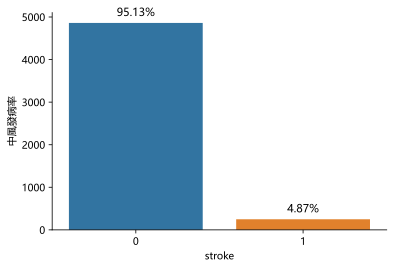

In [22]:
#數據集分佈情況
ax = sns.countplot("stroke",data=data)
plt.ylabel("中風發病率")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
for p in ax.patches:
    ax.annotate(f"{p.get_height()*100/data.shape[0]:.2f}%",(p.get_x()+p.get_width()/2,p.get_height()),
               ha="center",va="center",fontsize=11,color="black",rotation=0,xytext=(0,10),textcoords = "offset points")
plt.show()

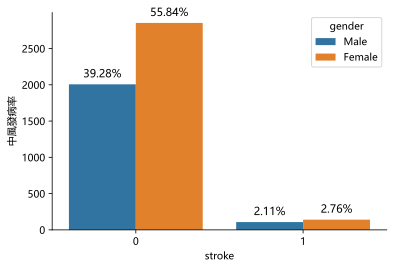

In [23]:
#性別與發病率的關係
ax = sns.countplot("stroke",hue="gender",data=data)
plt.ylabel("中風發病率")
annot_plot(ax)
plt.show()

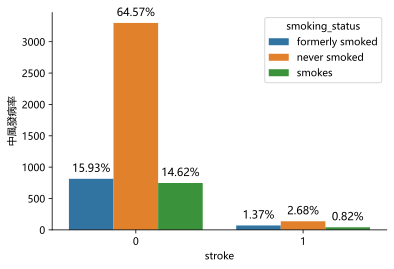

In [24]:
#吸煙狀態與中風發病率的關係
ax = sns.countplot("stroke",hue="smoking_status",data=data)
plt.ylabel("中風發病率")
annot_plot(ax)
plt.show()

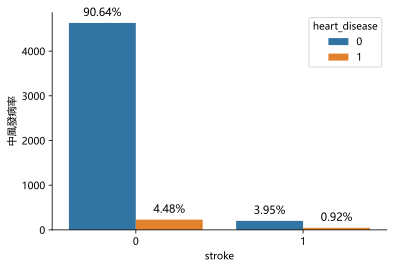

In [25]:
#中風與心髒病的關係
ax=sns.countplot("stroke",hue="heart_disease",data=data)
plt.ylabel("中風發病率")
annot_plot(ax)
plt.show()

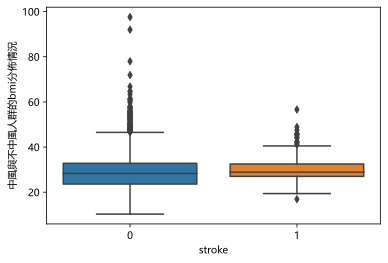

In [26]:
#bmi箱線圖
sns.boxplot(x="stroke",y="bmi",data=data)
plt.ylabel("中風與不中風人群的bmi分佈情況")
plt.show()

<AxesSubplot:ylabel='Density'>

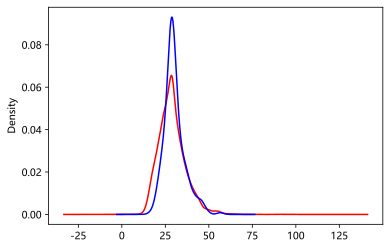

In [27]:
#bmi分佈密度圖
data["bmi"].plot.kde(color="red")
#患病用戶密度分佈
data.query("stroke==1")["bmi"].plot.kde(color="blue")

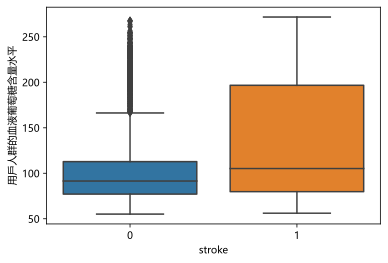

In [28]:
#血液中的葡萄糖水平的分佈
sns.boxplot(x="stroke",y="avg_glucose_level",data=data)
plt.ylabel("用戶人群的血液葡萄糖含量水平")
plt.show()


<AxesSubplot:ylabel='Density'>

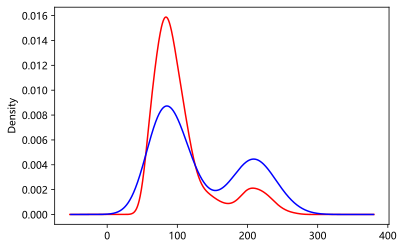

In [29]:
#avg_glucose_level分佈密度圖
data["avg_glucose_level"].plot.kde(color="red")
#患病用戶密度分佈
data.query("stroke==1")["avg_glucose_level"].plot.kde(color="blue")

In [30]:
#提取特徵
charges = data.drop(["id"],axis=1)
corrDf = charges.apply(lambda x:pd.factorize(x)[0])
corrDf.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,1,1,1,1,1,0
2,0,2,0,0,0,0,1,2,2,1,0
3,1,3,0,1,0,0,0,3,3,2,0
4,1,4,1,1,0,1,1,4,4,1,0


In [31]:
#構造相關性矩陣
corr=corrDf.corr()
corr

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
gender,1.000000,-0.008613,-0.021223,0.085685,-0.030171,-0.065848,-0.006105,0.007023,0.028407,0.021312,0.009081
age,-0.008613,1.000000,-0.220881,0.203917,0.523630,0.234249,0.019538,0.072558,0.125254,0.091543,0.216443
hypertension,-0.021223,-0.220881,1.000000,-0.108292,-0.164187,-0.075150,0.007980,-0.048336,-0.037028,-0.019315,-0.127891
heart_disease,0.085685,0.203917,-0.108292,1.000000,0.114601,0.058301,0.003045,0.054081,0.087604,0.016452,0.134905
ever_married,-0.030171,0.523630,-0.164187,0.114601,1.000000,0.376238,0.005988,0.027844,0.113458,0.047306,0.108299
work_type,-0.065848,0.234249,-0.075150,0.058301,0.376238,1.000000,-0.014426,0.028647,0.178520,-0.019389,0.058261
Residence_type,-0.006105,0.019538,0.007980,0.003045,0.005988,-0.014426,1.000000,0.006394,-0.030769,-0.011823,0.015415
avg_glucose_level,0.007023,0.072558,-0.048336,0.054081,0.027844,0.028647,0.006394,1.000000,0.112135,0.016570,0.350598
bmi,0.028407,0.125254,-0.037028,0.087604,0.113458,0.178520,-0.030769,0.112135,1.000000,-0.011421,0.191475
smoking_status,0.021312,0.091543,-0.019315,0.016452,0.047306,-0.019389,-0.011823,0.016570,-0.011421,1.000000,0.037144


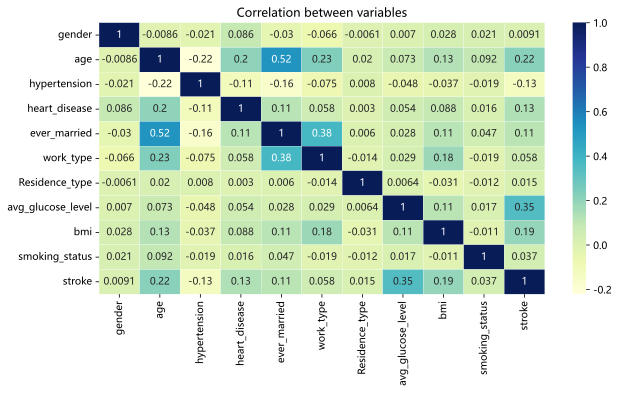

In [32]:
#繪製相關係數熱力地圖
plt.figure(figsize=(10,5),dpi=80)
ax = sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,
                linewidths=0.2,cmap="YlGnBu",annot=True)
plt.title("Correlation between variables")
plt.show()

In [33]:
#使用one_hot編碼查看數據之間的關係
one_hot_data = pd.get_dummies(data.iloc[:,1:])
one_hot_data.head(2)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67,0,1,228.69,36.60000,1,0,1,0,1,0,0,1,0,0,0,1,1,0,0
1,61,0,0,202.21,28.89456,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0


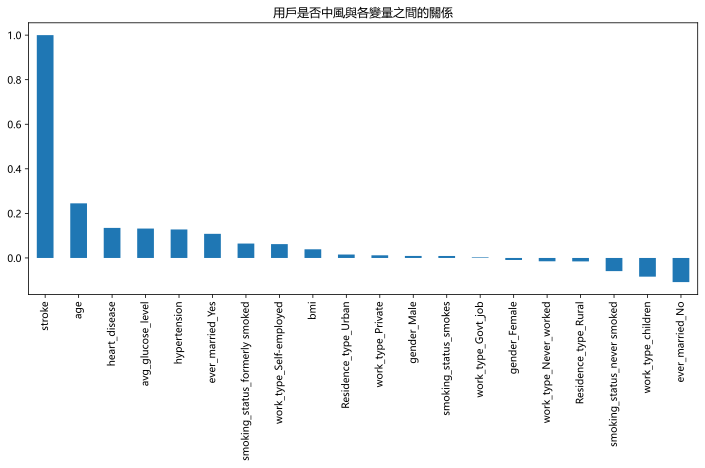

In [34]:
#用戶是否有中風與各變量之間的關係
plt.figure(figsize=(12,5))
one_hot_data.corr()["stroke"].sort_values(ascending=False).plot(kind="bar")
plt.title("用戶是否中風與各變量之間的關係")
plt.show()

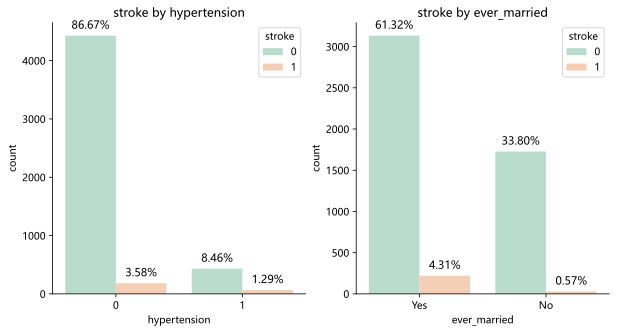

In [35]:
#中風與高血壓和婚姻狀態的關係
coveriables=["hypertension","ever_married"]
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
for i,item in enumerate(coveriables): #enumerate()函數用於將一個可遍歷的數據對象(如列表、元組或字符串)組合為一個索引序列，同時列出數據和數據下標，一般用在 for 循環當中。
    plt.subplot(1,2,(i+1))
    ax = sns.countplot(x=item,hue="stroke",data=data,palette="Pastel2")
    """countplot參數說明：Python數據可視化-seaborn庫之countplot - cymx66688 - 博客園"""
    plt.xlabel(str(item))
    plt.title("stroke by "+str(item))
    i=i+1
    annot_plot(ax)
plt.show()

In [36]:
#計算年齡分佈
age_data = data.pivot_table(index="age",columns="stroke",values="id",aggfunc="count")
age_data.head()

stroke,0,1
age,,
0,43.0,NaN
1,76.0,1.0
2,55.0,NaN
3,46.0,NaN
4,34.0,NaN


<AxesSubplot:xlabel='age'>

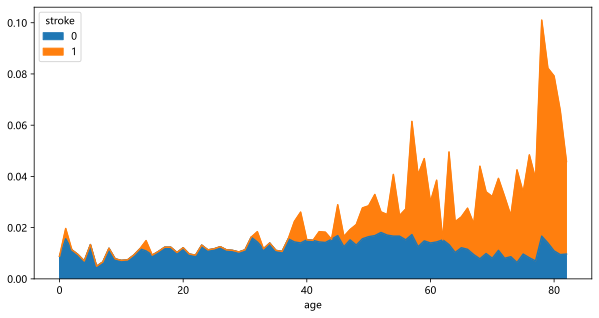

In [37]:
#求百分比繪圖,更能準確反應區別
age_data = age_data.apply(lambda x:x/x.sum())
#繪製堆積面積圖
age_data.plot.area(figsize=(10,5))

In [38]:
#選擇特徵值
data_comvar = data.drop(["id","gender","Residence_type","stroke"],axis=1)
data_comvar.head(2)

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
0,67,0,1,Yes,Private,228.69,36.60000,formerly smoked
1,61,0,0,Yes,Self-employed,202.21,28.89456,never smoked


In [39]:
#對連續變量進行標準化處理
scaler = StandardScaler(copy=False)
#fit_transform()先擬合數據，然後轉化數據將其變成標準形式
scaler.fit_transform(data_comvar[["age","avg_glucose_level","bmi"]])

array([[ 1.05075789e+00,  2.70644995e+00,  1.00103390e+00],
       [ 7.85653384e-01,  2.12165168e+00,  1.38462701e-15],
       [ 1.62515099e+00, -4.86741416e-03,  4.68392163e-01],
       ...,
       [-3.63132808e-01, -5.11265616e-01,  2.21558189e-01],
       [ 3.43812541e-01,  1.32837547e+00, -4.28004903e-01],
       [ 3.45239508e-02, -4.60692049e-01, -3.50057332e-01]])

In [40]:
#替換數據
data_comvar[["age","avg_glucose_level","bmi"]] = scaler.fit_transform(data_comvar[["age","avg_glucose_level","bmi"]])
data_comvar[["age","avg_glucose_level","bmi"]]

,age,avg_glucose_level,bmi
0,1.050758,2.706450,1.001034e+00
1,0.785653,2.121652,1.384627e-15
2,1.625151,-0.004867,4.683922e-01
3,0.255444,1.437473,7.152261e-01
4,1.580967,1.501297,-6.358651e-01
...,...,...,...
5105,1.625151,-0.494481,1.384627e-15
5106,1.669335,0.420922,1.442737e+00
5107,-0.363133,-0.511266,2.215582e-01
5108,0.343813,1.328375,-4.280049e-01


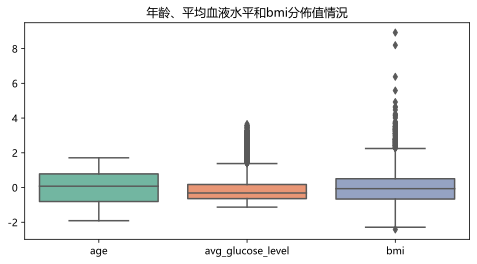

In [41]:
#使用箱線圖查看是否存在異常值
plt.figure(figsize=(8,4),dpi=80)
numbox=sns.boxplot(data=data_comvar[["age","avg_glucose_level","bmi"]],palette="Set2")
plt.title("年齡、平均血液水平和bmi分佈值情況")
plt.show()

In [42]:
#剔除異常值
"""定義函數：
允許函數輸入空值
data：表示dataFrame類型
n：表示被多少個特徵同時判定為異常點才輸出
features：表示檢測異常點的特徵
"""
def detect_outliers(data,n,features):
    outlier_indices=[]
    for col in features:
        #第一個四分位點
        #Q1 = data[col].describe()["25%"]
        Q1=np.percentile(data[col],25)
        #第三個四分位點
        #Q3 = data[col].describe()["75%"]
        Q3=np.percentile(data[col],75)
        IQR = Q3-Q1
        #極端上限和下限
        lower_limit = Q1-1.5*IQR
        upper_limit = Q3+1.5*IQR
        #查詢異常值的索引
        outlier_col = data[(data[col]<lower_limit)|(data[col]>upper_limit)].index
        #保存
        outlier_indices.extend(outlier_col)
    from collections import Counter
    outlier_indices = Counter(outlier_indices)
    #若被n特特徵同時判定為異常點才輸出
    more_outliers = list(k for k,v in outlier_indices.items() if v>=n)
    return more_outliers

In [43]:
#異常值的索引
outliers = detect_outliers(data_comvar,2,["avg_glucose_level","bmi"])
outliers

[21,
 66,
 113,
 254,
 258,
 417,
 466,
 544,
 595,
 1061,
 1257,
 1322,
 1529,
 1782,
 1898,
 2067,
 2081,
 2284,
 2290,
 2893,
 3060,
 3238,
 3243,
 3439,
 3594,
 3606,
 3688,
 3909,
 3931,
 3959,
 3980,
 4475,
 4636,
 4952]

In [44]:
#刪除特徵數據集異常值
data_comvar = data_comvar.drop(outliers,axis=0).reset_index(drop=True)
data_comvar.head(2)

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
0,1.050758,0,1,Yes,Private,2.706450,1.001034e+00,formerly smoked
1,0.785653,0,0,Yes,Self-employed,2.121652,1.384627e-15,never smoked


In [45]:
#刪除原數據集異常值
data = data.drop(outliers,axis=0).reset_index(drop=True)
data.head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.60000,formerly smoked,1
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,28.89456,never smoked,1


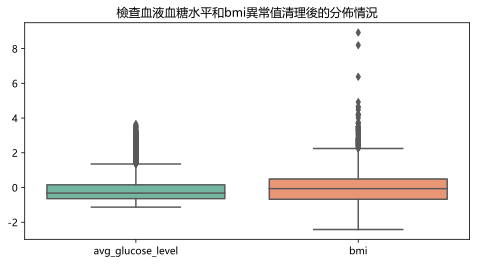

In [46]:
#檢查異常值是否清理完成
plt.figure(figsize=(8,4),dpi=80)
numbox = sns.boxplot(data = data_comvar[["avg_glucose_level","bmi"]],palette="Set2")
plt.title("檢查血液血糖水平和bmi異常值清理後的分佈情況")
plt.show()

In [47]:
#查看對像類型字段裡面存在的值
def uni(columnlabel):
    print(columnlabel,"-----",data_comvar[columnlabel].unique())
data_comvar_object = data_comvar.select_dtypes(["object"])
for i in range(0,len(data_comvar_object.columns)):
    uni(data_comvar_object.columns[i])

ever_married ----- ['Yes' 'No']
work_type ----- ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
smoking_status ----- ['formerly smoked' 'never smoked' 'smokes']


In [48]:
#使用scikit_learn標籤編碼，將分類數據轉換為整數編碼
def labelencode(columnlabel):
    data_comvar[columnlabel] = LabelEncoder().fit_transform(data_comvar[columnlabel])
#進行標籤編碼：
for i in range(0,len(data_comvar_object.columns)):
    labelencode(data_comvar_object.columns[i])
#展示
for i in range(0,len(data_comvar_object.columns)):
    uni(data_comvar_object.columns[i])

ever_married ----- [1 0]
work_type ----- [2 3 0 4 1]
smoking_status ----- [0 1 2]


In [49]:
#查看特徵處理完畢的數據集情況
data_comvar.head()

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
0,1.050758,0,1,1,2,2.706450,1.001034e+00,0
1,0.785653,0,0,1,3,2.121652,1.384627e-15,1
2,1.625151,0,1,1,2,-0.004867,4.683922e-01,1
3,0.255444,0,0,1,2,1.437473,7.152261e-01,2
4,1.580967,1,0,1,3,1.501297,-6.358651e-01,1


In [50]:
#****************************************


In [51]:
# 1、建立訓練和測試數據集
"""拆分數據集時，由於我們的數據集是不平衡的，所以最好使用分層交叉驗證來確保訓練集和測試集都包含每個類樣本的保留人數。
交叉驗證函數StratifiedShuffleSplit，分層抽樣功能保每個標籤對應的樣本的比例，是從樣本數據中隨機按比例選擇訓練數據和測試數據
參數n_splite是將訓練數據分成train/test對的組數，可根據需要進行設置，默認為10
參數test_size和train_size是用來設置train/test對中train和test所佔的比例
參數random_state 控制是將樣本隨機打亂
"""
X=data_comvar
y=data["stroke"].values

spl = StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=42)
print(spl)
print("訓練數據集和測試數據集被分成的組數：",spl.get_n_splits(X,y))

StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None)
訓練數據集和測試數據集被分成的組數： 5


In [52]:
#目標y值
data["stroke"].values

array([1, 1, 1, ..., 0, 0, 0])

In [53]:
#查看訓練數據集和測試數據集
for train_index,test_index in spl.split(X,y):
    print("train:",train_index,"test:",test_index)
    X_train,X_test=X.iloc[train_index],X.iloc[test_index]
    y_train,y_test = y[train_index],y[test_index]

train: [3505  971  636 ...  737 3688 4170] test: [2307 2611 4900 ... 4002 2728 1739]
train: [1130 1517 3354 ... 4448 4762 3832] test: [3596 4584 4652 ... 3326 1124 2139]
train: [2291 2230  500 ... 1622 1787 3362] test: [4640  939 1466 ... 3963 3698 4920]
train: [3948  221 2879 ... 3274 4091 1733] test: [1178 2400 2168 ...  488 1530 5067]
train: [4990 1275  795 ... 2890 2648 3468] test: [4811 3925 4098 ... 3531 1051  354]


In [54]:
#輸出數據集大小
print("原始數據集特徵：",X.shape,
     "訓練數據集特徵：",X_train.shape,
     "測試數據集特徵：",X_test.shape)
print("原始數據集標籤：",y.shape,
     "訓練數據集標籤：",y_train.shape,
     "測試數據集標籤：",y_test.shape)

原始數據集特徵： (5075, 8) 訓練數據集特徵： (4060, 8) 測試數據集特徵： (1015, 8)
原始數據集標籤： (5075,) 訓練數據集標籤： (4060,) 測試數據集標籤： (1015,)


In [55]:
y_train=pd.Series(y_train)

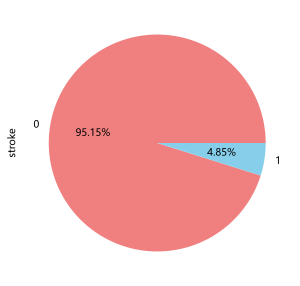

In [56]:
import matplotlib.pyplot as plt
plt.figure( figsize=(10,5) )
y_train.value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
#plt.title( 'Pass/Fail' )  # 圖標題
plt.ylabel( 'stroke' )
plt.show()

In [57]:
#採用SMOTE處理數據不平衡問題
#smo = SMOTE(random_state=42)
#x_smo,y_smo = smo.fit_resample(X_train,y_train)
#print(x_smo.shape,y_smo.shape)

from imblearn.over_sampling import SMOTE
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

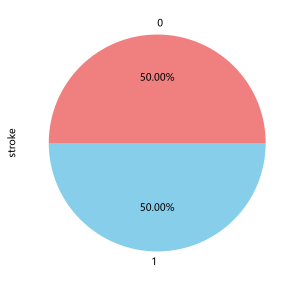

In [58]:
import matplotlib.pyplot as plt
plt.figure( figsize=(10,5) )
y_train.value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
#plt.title( 'Pass/Fail' )  # 圖標題
plt.ylabel( 'stroke' )
plt.show()

In [59]:
#2、選擇機器學習算法
"""使用分類算法，這裡選擇十種分類算法"""
Classifiers=[
    ["Random Forest",RandomForestClassifier()],
    ["Support Vector Machine",SVC()],
    ["LogisticRegression",LogisticRegression()],
    ["KNN",KNeighborsClassifier()],
    ["Naive Bayes",GaussianNB()],
    ["Decision Tree",DecisionTreeClassifier()],
    ["AdaBoostClassifier",AdaBoostClassifier()],
    ["GradientBoostingClassifier",GradientBoostingClassifier()],
    ["XGB",XGBClassifier()],
    ["CatBoost",CatBoostClassifier()]
]

In [60]:
from sklearn.metrics import roc_auc_score
#3、訓練模型
Classify_result=[]
names=[]
prediction=[]
for name,classifier in Classifiers:
    classifier = classifier
    #訓練模型
    classifier.fit(X_train,y_train) #*****
    #目標预测值
    y_pred = classifier.predict(X_test)
    #召回率
    recall = recall_score(y_test,y_pred)
    #準確率
    precision = precision_score(y_test,y_pred)
    #f1综合得分
    f1 = f1_score(y_test,y_pred)
    #準確度
    accuracy=accuracy_score(y_test,y_pred)
    #
    ROC_score=roc_auc_score(y_test,y_pred)
    #評估結果合併
    class_eva = pd.DataFrame([recall,precision,f1,accuracy,ROC_score])
    Classify_result.append(class_eva)
    #模型名稱
    name=pd.Series(name)
    names.append(name)
    #預測結果
    y_pred = pd.Series(y_pred)
    prediction.append(y_pred)

Learning rate set to 0.024666
0:	learn: 0.6759239	total: 148ms	remaining: 2m 28s
1:	learn: 0.6593955	total: 158ms	remaining: 1m 18s
2:	learn: 0.6445456	total: 168ms	remaining: 55.8s
3:	learn: 0.6313438	total: 174ms	remaining: 43.4s
4:	learn: 0.6190454	total: 177ms	remaining: 35.3s
5:	learn: 0.6068516	total: 181ms	remaining: 29.9s
6:	learn: 0.5952546	total: 184ms	remaining: 26.1s
7:	learn: 0.5848874	total: 187ms	remaining: 23.2s
8:	learn: 0.5739900	total: 190ms	remaining: 20.9s
9:	learn: 0.5636335	total: 193ms	remaining: 19.1s
10:	learn: 0.5551080	total: 195ms	remaining: 17.5s
11:	learn: 0.5465349	total: 198ms	remaining: 16.3s
12:	learn: 0.5382679	total: 201ms	remaining: 15.2s
13:	learn: 0.5297659	total: 203ms	remaining: 14.3s
14:	learn: 0.5219384	total: 206ms	remaining: 13.5s
15:	learn: 0.5170789	total: 209ms	remaining: 12.8s
16:	learn: 0.5101323	total: 211ms	remaining: 12.2s
17:	learn: 0.5047719	total: 214ms	remaining: 11.7s
18:	learn: 0.4999030	total: 217ms	remaining: 11.2s
19:	learn

In [61]:
#4、評估模型
"""recall召回率：原本為對的當中，預測為對的比例（值越大越好，1為理想狀態）
precision精確率：預測為對的當中，原本為對的比例（值越大越好，1為理想狀態）
F1-Score F1分數：指標綜合了Precision和recall的產出結果
F1-Score取值範圍0-1，1代表模型輸出的結果最好，0代表模型輸出結果最差
"""
names = pd.DataFrame(names)
names = names[0].tolist()
#將各個結果合併在一起
result = pd.concat(Classify_result,axis=1)
result.columns = names
result.index=["recall","precision","F1_score","accuracy_score","ROC_score"]
result

,Random Forest,Support Vector Machine,LogisticRegression,KNN,Naive Bayes,Decision Tree,AdaBoostClassifier,GradientBoostingClassifier,XGB,CatBoost
recall,0.265306,0.591837,0.714286,0.408163,0.755102,0.224490,0.673469,0.510204,0.102041,0.142857
precision,0.125000,0.108614,0.128676,0.103093,0.122517,0.117021,0.122222,0.126904,0.128205,0.109375
F1_score,0.169935,0.183544,0.218069,0.164609,0.210826,0.153846,0.206897,0.203252,0.113636,0.123894
accuracy_score,0.874877,0.745813,0.752709,0.800000,0.727094,0.880788,0.750739,0.806897,0.923153,0.902463
ROC_score,0.585552,0.672730,0.734472,0.614020,0.740387,0.569284,0.714064,0.666075,0.533422,0.541925


In [62]:
#預測數據集特徵
pred_X = data_comvar.tail(100)
#提取id
pred_id = data["id"].tail(100)

#使用樸素貝葉斯方法，預測用戶中風情況
model = GradientBoostingClassifier()
model.fit(X_train,y_train)
pred_y = model.predict(pred_X)

#預測結果
predDf = pd.DataFrame({"id":pred_id,"stroke":pred_y})
predDf

,id,stroke
4975,58635,0
4976,844,1
4977,14688,0
4978,23026,0
4979,30463,0
...,...,...
5070,18234,1
5071,44873,0
5072,19723,0
5073,37544,0


In [63]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
#fitting the x and y values
lr.fit(X_train,y_train)

LogisticRegression()

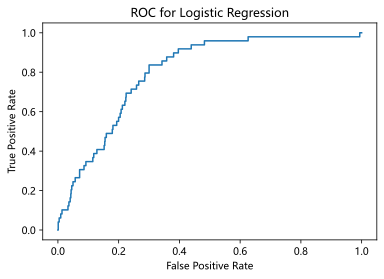

In [64]:
#define metrics
y_pred_proba = lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC for Logistic Regression')
plt.show()

In [65]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import time

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [66]:
accuracy_selection = []
cvs_selection = []
roc_auc = []
recall = []

[[877  89]
 [ 36  13]]
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       966
           1       0.13      0.27      0.17        49

    accuracy                           0.88      1015
   macro avg       0.54      0.59      0.55      1015
weighted avg       0.92      0.88      0.90      1015

Random Forest accuracy:  0.950935960591133
Random Forest f1:  0.023227752639517346
Random Forest roc_auc:  0.8078902027286633
Random Forest Accuracy: 0.8768472906403941


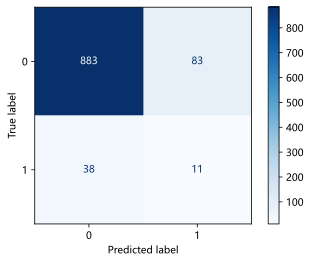

In [67]:
model_RandomForestClassifier = RandomForestClassifier()
model_RandomForestClassifier.fit(X_train, y_train)
model_RandomForestClassifier_prediction = model_RandomForestClassifier.predict(X_test)
model_RandomForestClassifier_scores = cross_val_score(model_RandomForestClassifier, X, y, cv=10)

model_RF_y_score = model_RandomForestClassifier.fit(X_train, y_train).predict_proba(X_test)
fpr_RF_model, tpr_RF_model,_ = metrics.roc_curve(np.array(y_test), model_RF_y_score[::,1])

roc_auc.append(metrics.auc(fpr_RF_model,tpr_RF_model)) ###計算auc的值
accuracy_selection.append(accuracy_score(model_RandomForestClassifier_prediction, y_test))
cvs_selection.append(np.mean(model_RandomForestClassifier_scores))

print(confusion_matrix(y_test, model_RandomForestClassifier_prediction))
print(classification_report(y_test, model_RandomForestClassifier_prediction))

cv_results = cross_validate(model_RandomForestClassifier, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("Random Forest accuracy: ", cv_results['test_accuracy'].mean())
print("Random Forest f1: ", cv_results['test_f1'].mean())
print("Random Forest roc_auc: ", cv_results['test_roc_auc'].mean())

print("Random Forest Accuracy: {0}".format(accuracy_score(model_RandomForestClassifier_prediction, y_test)))
# print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(model_RandomForestClassifier_scores), np.std(model_RandomForestClassifier_scores)*2))

model_RandomForestClassifier_pred_test_y = model_RandomForestClassifier.predict(X_test)
metrics.plot_confusion_matrix(model_RandomForestClassifier, X_test.values, y_test, cmap='Blues')
plt.grid(False)

[[877  89]
 [ 36  13]]
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       966
           1       0.12      0.24      0.16        49

    accuracy                           0.88      1015
   macro avg       0.54      0.58      0.55      1015
weighted avg       0.92      0.88      0.90      1015

DecisionTree accuracy:  0.9495566502463054
DecisionTree f1:  0.014965034965034962
DecisionTree roc_auc:  0.8011044229180746
Dedicion Tree Accuracy: 0.8758620689655172


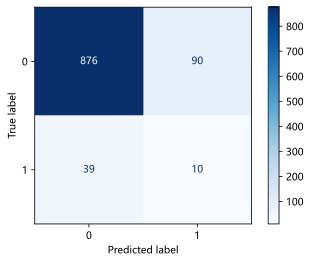

In [68]:
model_DecisionTreeClassifier = DecisionTreeClassifier()
model_DecisionTreeClassifier.fit(X_train, y_train)
model_DecisionTreeClassifier_prediction = model_DecisionTreeClassifier.predict(X_test)
model_DecisionTreeClassifier_scores = cross_val_score(model_DecisionTreeClassifier, X, y, cv=10)

model_DT_y_score = model_DecisionTreeClassifier.fit(X_train, y_train).predict_proba(X_test)
fpr_DT_model, tpr_DT_model,_ = metrics.roc_curve(np.array(y_test), model_DT_y_score[::,1])

roc_auc.append(metrics.auc(fpr_DT_model,tpr_DT_model)) ###計算auc的值
accuracy_selection.append(accuracy_score(model_DecisionTreeClassifier_prediction, y_test))
cvs_selection.append(np.mean(model_DecisionTreeClassifier_scores))

print(confusion_matrix(y_test, model_RandomForestClassifier_prediction))
print(classification_report(y_test, model_DecisionTreeClassifier_prediction))


cv_results = cross_validate(model_RandomForestClassifier, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("DecisionTree accuracy: ", cv_results['test_accuracy'].mean())
print("DecisionTree f1: ", cv_results['test_f1'].mean())
print("DecisionTree roc_auc: ", cv_results['test_roc_auc'].mean())

print("Dedicion Tree Accuracy: {0}".format(accuracy_score(model_DecisionTreeClassifier_prediction, y_test)))
# print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(model_DecisionTreeClassifier_scores), np.std(model_DecisionTreeClassifier_scores)*2))

model_DecisionTreeClassifier_pred_test_y = model_DecisionTreeClassifier.predict(X_test)
metrics.plot_confusion_matrix(model_DecisionTreeClassifier, X_test.values, y_test, cmap='Blues')
plt.grid(False)

[[729 237]
 [ 14  35]]
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       966
           1       0.13      0.71      0.22        49

    accuracy                           0.75      1015
   macro avg       0.55      0.73      0.54      1015
weighted avg       0.94      0.75      0.82      1015

Logistic Regression accuracy:  0.9499507389162561
Logistic Regression f1:  0.022512204776355717
Logistic Regression roc_auc:  0.8090291370485698
Logistic Regression Accuracy: 0.7527093596059113


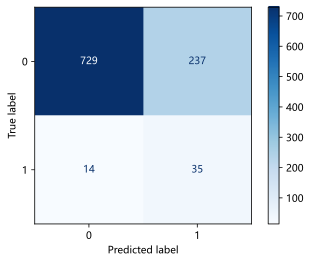

In [69]:
from sklearn.linear_model import LogisticRegression
model_LR = LogisticRegression(solver='lbfgs', max_iter=1000)
model_LR.fit(X_train, y_train)
model_LR_prediction = model_LR.predict(X_test)
model_LR_scores = cross_val_score(model_LR, X, y, cv=10)

model_LR_y_score = model_LR.fit(X_train, y_train).predict_proba(X_test)
fpr_LR_model, tpr_LR_model,_ = metrics.roc_curve(np.array(y_test), model_LR_y_score[::,1])

roc_auc.append(metrics.auc(fpr_LR_model,tpr_LR_model)) ###計算auc的值
accuracy_selection.append(accuracy_score(model_LR_prediction, y_test))
cvs_selection.append(np.mean(model_LR_scores))

print(confusion_matrix(y_test, model_LR_prediction))
print(classification_report(y_test, model_LR_prediction))

cv_results = cross_validate(model_RandomForestClassifier, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("Logistic Regression accuracy: ", cv_results['test_accuracy'].mean())
print("Logistic Regression f1: ", cv_results['test_f1'].mean())
print("Logistic Regression roc_auc: ", cv_results['test_roc_auc'].mean())

print("Logistic Regression Accuracy: {0}".format(accuracy_score(model_LR_prediction, y_test)))
# print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(model_DecisionTreeClassifier_scores), np.std(model_DecisionTreeClassifier_scores)*2))

model_LR_pred_test_y = model_LR.predict(X_test)
metrics.plot_confusion_matrix(model_LR, X_test.values, y_test, cmap='Blues')
plt.grid(False)

預設ACC: 0.8
CV: 0.948767229664143
confusion_matrix
[[792 174]
 [ 29  20]]
              precision    recall  f1-score   support

           0       0.96      0.82      0.89       966
           1       0.10      0.41      0.16        49

    accuracy                           0.80      1015
   macro avg       0.53      0.61      0.53      1015
weighted avg       0.92      0.80      0.85      1015

----------------------------------------
ACC: 0.8403940886699507
CV: 0.9221704523393516
confusion_matrix
[[838 128]
 [ 34  15]]
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       966
           1       0.10      0.31      0.16        49

    accuracy                           0.84      1015
   macro avg       0.53      0.59      0.53      1015
weighted avg       0.92      0.84      0.88      1015



Text(30.5, 0.5, 'true')

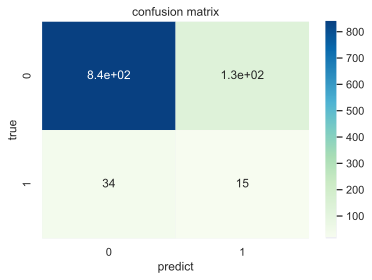

In [70]:
#KNN
kn = KNeighborsClassifier().fit(X_train,y_train)
predict = kn.predict(X_test)
#已預設的N=5進行KNN
print("預設ACC:",accuracy_score(y_test,predict))
R2CV = cross_val_score(kn,X_test,y_test,cv=10).mean()
print("CV:",R2CV)
# 均方誤差（MSE）度量的是預測值和實際觀測值間差的平方的均值，誤差越小越好
#error = mean_squared_error(y_test,predict)
#print("RMSE",np.sqrt(error))
print("confusion_matrix")
print(confusion_matrix(y_test, predict))
print(classification_report(y_test, predict))
print("----------------------------------------")

#要找到 的最佳價值k，您將使用一個名為 的工具GridSearchCV。這是一種經常用於調整機器學習模型的超參數的工具。在您的情況下，它將通過自動找到k數據集的最佳值來提供幫助。
#params = {"n_neighbors": np.arange(1,50)}
#cv = GridSearchCV(kn,params,cv=10).fit(X_train,y_train)
#print(cv.best_params_)
#print(cv.best_score_)#交叉驗證中最好的結果
#'n_neighbors': 1->最佳knn為1

kntuned = KNeighborsClassifier(n_neighbors=1).fit(X_train,y_train)
predicttuned = kntuned.predict(X_test)

print("ACC:",accuracy_score(y_test,predicttuned))
R2CVtuned = cross_val_score(kntuned,X_test,y_test,cv=10).mean()
print("CV:",R2CVtuned)

#errortuned = mean_squared_error(y_test,predicttuned)
#print("RMSE",np.sqrt(errortuned))
print("confusion_matrix")
print(confusion_matrix(y_test, predicttuned))
print(classification_report(y_test, predicttuned))

sns.set()
f,ax=plt.subplots()
C2= confusion_matrix(y_test, predicttuned)
sns.heatmap(C2, annot=True, ax=ax, cmap = "GnBu") #畫熱力圖

ax.set_title('confusion matrix') #標題
ax.set_xlabel('predict') #x軸
ax.set_ylabel('true') #y軸


[[728 238]
 [ 20  29]]
              precision    recall  f1-score   support

           0       0.97      0.75      0.85       966
           1       0.11      0.59      0.18        49

    accuracy                           0.75      1015
   macro avg       0.54      0.67      0.52      1015
weighted avg       0.93      0.75      0.82      1015

SVM accuracy:  0.9515270935960591
SVM f1:  0.0
SVM roc_auc:  0.6592559419983356
SVM Accuracy: 0.7458128078817734


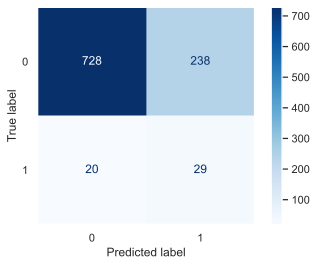

In [80]:
from sklearn.svm import SVC
model_SVM = SVC(kernel='rbf',degree=3,gamma='auto',coef0=0.0,shrinking=True,probability=True)
model_SVM.fit(X_train, y_train)
model_SVM_prediction = model_SVM.predict(X_test)
model_SVM_scores = cross_val_score(model_SVM, X, y, cv=10)

model_SVM_y_score = model_SVM.fit(X_train, y_train).predict_proba(X_test)
fpr_SVM_model, tpr_SVM_model,_ = metrics.roc_curve(np.array(y_test), model_SVM_y_score[::,1])

roc_auc.append(metrics.auc(fpr_SVM_model,tpr_SVM_model)) ###計算auc的值
accuracy_selection.append(accuracy_score(model_SVM_prediction, y_test))
cvs_selection.append(np.mean(model_SVM_scores))

print(confusion_matrix(y_test, model_SVM_prediction))
print(classification_report(y_test, model_SVM_prediction))

cv_results = cross_validate(model_SVM, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("SVM accuracy: ", cv_results['test_accuracy'].mean())
print("SVM f1: ", cv_results['test_f1'].mean())
print("SVM roc_auc: ", cv_results['test_roc_auc'].mean())

print("SVM Accuracy: {0}".format(accuracy_score(model_SVM_prediction, y_test)))
# print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(model_DecisionTreeClassifier_scores), np.std(model_DecisionTreeClassifier_scores)*2))

model_SVM_pred_test_y = model_SVM.predict(X_test)
metrics.plot_confusion_matrix(model_SVM, X_test.values, y_test, cmap='Blues')
plt.grid(False)

In [ ]:
#***************************

ACC: 0.8768472906403941
CV: 0.9517278198408075
[[879  87]
 [ 38  11]]
Accuracy: 0.8768472906403941
Precision: 0.11224489795918367
Recall: 0.22448979591836735
F1-score: 0.14965986394557823
Sencificity: 0.22448979591836735
Specificity: 0.9099378881987578
AUC: 0.5672138420585625
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       966
           1       0.11      0.22      0.15        49

    accuracy                           0.88      1015
   macro avg       0.54      0.57      0.54      1015
weighted avg       0.92      0.88      0.90      1015



Text(30.5, 0.5, 'true')

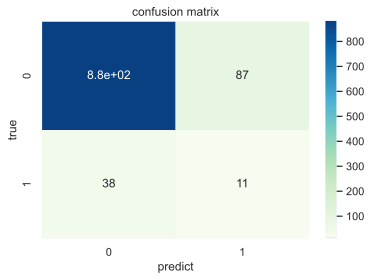

In [95]:

model_RandomForestClassifier = RandomForestClassifier()
model_RandomForestClassifier.fit(X_train, y_train)
model_RandomForestClassifier_prediction = model_RandomForestClassifier.predict(X_test)
model_RandomForestClassifier_scores = cross_val_score(model_RandomForestClassifier, X, y, cv=10)
#model_DecisionTreeClassifier = DecisionTreeClassifier()
#model_DecisionTreeClassifier.fit(X_train, y_train)
#model_DecisionTreeClassifier_prediction = model_DecisionTreeClassifier.predict(X_test)
#model_DecisionTreeClassifier_scores = cross_val_score(model_DecisionTreeClassifier, X, y, cv=10)
#kn = KNeighborsClassifier().fit(X_train,y_train)
#predict = kn.predict(X_test)
#model_SVM = SVC(kernel='rbf',degree=3,gamma='auto',coef0=0.0,shrinking=True,probability=True)
#model_SVM.fit(X_train, y_train)
#model_SVM_prediction = model_SVM.predict(X_test)
#model_SVM_scores = cross_val_score(model_SVM, X, y, cv=10)

#params = {"max_depth": [2, 5, 8, 10],
#          "max_features": [2, 5, 8],
 #         "n_estimators": [10, 500, 1000],
  #        "min_samples_split": [2, 5, 10]}

#cv = GridSearchCV(model_RandomForestClassifier,params,cv=10,verbose=False,n_jobs=-1).fit(X_train,y_train)
#print(cv.best_params_)

rfctuned = model_RandomForestClassifier

predicttuned = rfctuned.predict(X_test)
print("ACC:",accuracy_score(y_test,predicttuned))
R2CVtuned = cross_val_score(rfctuned,X_test,y_test,cv=10).mean()
print("CV:",R2CVtuned)
# 0.83
#errortuned = mean_squared_error(y_test,predicttuned)
#print("RMSE:",np.sqrt(errortuned))

rfctuned = model_RandomForestClassifier
predicttuned = rfctuned.predict(X_test)
cf=confusion_matrix(y_test, predicttuned)
tp=cf[1,1]
tn=cf[0,0]
fp=cf[0,1]
fn=cf[1,0]
print(cf)
print("Accuracy:",(tp+tn)/float(tp+tn+fp+fn))
pre=tp/float(tp+fp)
print("Precision:",pre)
recall=tp/float(tp+fn)
print("Recall:",recall)
print("F1-score:",2/float((1/pre)+(1/recall)))
print("Sencificity:",tp/float(tp+fn))
print("Specificity:",tn/float(tn+fp))
auc = metrics.roc_auc_score (y_test, predicttuned)
print("AUC:",auc)
print(classification_report(y_test, predicttuned))

sns.set()
f,ax=plt.subplots()
C2= confusion_matrix(y_test, predicttuned)
sns.heatmap(C2, annot=True, ax=ax, cmap = "GnBu") #畫熱力圖

ax.set_title('confusion matrix') #標題
ax.set_xlabel('predict') #x軸
ax.set_ylabel('true') #y軸

In [71]:

model_KNN = KNeighborsClassifier(n_neighbors=2)
model_KNN.fit(X_train, y_train)
model_KNN_prediction = model_KNN.predict(X_test)
model_KNN_scores = cross_val_score(model_KNN, X, y, cv=10)

model_KNN_y_score = model_KNN.fit(X_train, y_train).predict_proba(X_test)
fpr_KNN_model, tpr_KNN_model,_ = metrics.roc_curve(np.array(y_test), model_KNN_y_score[::,1])

roc_auc.append(metrics.auc(fpr_KNN_model,tpr_KNN_model)) ###計算auc的值
accuracy_selection.append(accuracy_score(model_KNN_prediction, y_test))
cvs_selection.append(np.mean(model_KNN_scores))

print(confusion_matrix(y_test, model_KNN_prediction))
print(classification_report(y_test, model_KNN_prediction))

cv_results = cross_validate(KNeighborsClassifier, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("KNN accuracy: ", cv_results['test_accuracy'].mean())
print("KNN f1: ", cv_results['test_f1'].mean())
print("KNN roc_auc: ", cv_results['test_roc_auc'].mean())

print("KNN Accuracy: {0}".format(accuracy_score(model_KNN_prediction, y_test)))
# print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(model_DecisionTreeClassifier_scores), np.std(model_DecisionTreeClassifier_scores)*2))

model_KNN_pred_test_y = model_KNN.predict(X_test)
metrics.plot_confusion_matrix(model_KNN, X_test.values, y_test, cmap='Blues')
plt.grid(False)


[[867  99]
 [ 35  14]]
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       966
           1       0.12      0.29      0.17        49

    accuracy                           0.87      1015
   macro avg       0.54      0.59      0.55      1015
weighted avg       0.92      0.87      0.89      1015



TypeError: Cannot clone object. You should provide an instance of scikit-learn estimator instead of a class.

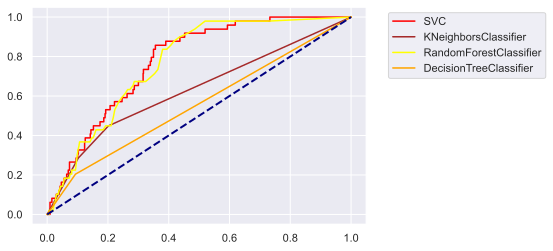

<Figure size 720x1440 with 0 Axes>

In [107]:
lw = 2
# metrics.roc_auc_score(np.array(y_test),y_score[::,1])
plt.plot(fpr_SVM_model,tpr_SVM_model,color='red',label="SVC")
plt.plot(fpr_KNN_model,tpr_KNN_model,color='brown',label="KNeighborsClassifier")
plt.plot(fpr_RF_model,tpr_RF_model,color='yellow',label="RandomForestClassifier")
plt.plot(fpr_DT_model,tpr_DT_model,color='orange',label="DecisionTreeClassifier")
#plt.plot(fpr_LR_model,tpr_LR_model,color='black',label="LogisticRegression")



plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.figure(figsize=(10,20))
plt.show()

In [101]:
fpr_RF_model



array([0.        , 0.0010352 , 0.00621118, 0.00621118, 0.00828157,
       0.01138716, 0.01242236, 0.01449275, 0.01759834, 0.01966874,
       0.02380952, 0.02587992, 0.02691511, 0.02795031, 0.0310559 ,
       0.0320911 , 0.03623188, 0.03933747, 0.04037267, 0.04451346,
       0.04658385, 0.05072464, 0.05693582, 0.0610766 , 0.063147  ,
       0.06832298, 0.06935818, 0.07246377, 0.07556936, 0.08074534,
       0.08074534, 0.08385093, 0.08592133, 0.09213251, 0.0931677 ,
       0.09937888, 0.10144928, 0.10455487, 0.10662526, 0.11283644,
       0.11801242, 0.1242236 , 0.12836439, 0.13354037, 0.13664596,
       0.14078675, 0.14699793, 0.15113872, 0.1563147 , 0.16045549,
       0.16977226, 0.18012422, 0.18426501, 0.19254658, 0.20082816,
       0.21014493, 0.2173913 , 0.22256729, 0.23602484, 0.24534161,
       0.25672878, 0.26501035, 0.27225673, 0.2826087 , 0.28674948,
       0.30848861, 0.32401656, 0.33954451, 0.35403727, 0.36438923,
       0.37991718, 0.39337474, 0.4068323 , 0.41718427, 0.43478

In [ ]:
#K Nearest Neighbors
model_KNN = KNeighborsClassifier(n_neighbors=2)
model_KNN.fit(X_train, y_train)
model_KNN_prediction = model_KNN.predict(X_test)

knn_conf = confusion_matrix(y_test, model_KNN_prediction)
a,b = plot_confusion_matrix(conf_mat = knn_conf,figsize=(10,10),cmap = 'Greens' )
plt.xlabel('Pred')
plt.ylabel('Actuals')
plt.title('CF')
plt.show()
knn_report = classification_report(y_test, knn_pred)
knn_acc = round(accuracy_score(y_test, knn_pred)*100, ndigits = 2)
print(f"Confusion Matrix : \n\n{knn_conf}")
print(f"\nClassification Report : \n\n{knn_report}")
print(f"\nThe Accuracy of K Nearest Neighbors Classifier is {knn_acc} %")